In [33]:
import os
import datetime
import pandas as pd
import numpy as np
import pandas_datareader.data as web

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
from sklearn.model_selection import TimeSeriesSplit 
from pmdarima.arima import auto_arima

## Gathering stocks

In [5]:
try:
    ### Local Storage
    apple = pd.read_csv("./data/apple_stock.csv")
except:
    ### Alpha Vantage API
    # os.environ["ALPHA_VANTAGE_API_KEY"] ="0LQY2GPX91HZXOYZ" 
    API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")

    # Define the start date for the data retrieval
    start = datetime.datetime(2023, 1, 1)
    end = datetime.datetime.today()

    apple = web.DataReader("AAPL", "av-daily", start=start, end=end, api_key=API_KEY)
    apple

#### Conclusion
This API is very fast and runs with no errors unlike those we have tried before (yfinance et al.)

## Save

In [63]:
def save_dataframe_to_csv(dataframe, file_path):
    if os.path.exists(file_path):
        response = input(f"The file '{file_path}' already exists. Do you want to overwrite it? (y/n): ")
        if response.lower() != 'y':
            print("File not overwritten.")
            return
    
    dataframe.to_csv(file_path, index=False)
    print(f"Dataframe saved to '{file_path}'.")

In [64]:
save_dataframe_to_csv(apple, "./data/apple_stock.csv")

The file './data/apple_stock.csv' already exists. Do you want to overwrite it? (y/n):  n


File not overwritten.


In [62]:
# apple.to_csv("./data/apple_stock.csv", index=True)

## Exploration

In [7]:
apple.dtypes

open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object

In [8]:
apple.isna().any()

open      False
high      False
low       False
close     False
volume    False
dtype: bool

### Preprocessing

In [9]:
# Making index into date time object
apple.set_index(pd.to_datetime(apple.reset_index().iloc[:,0]), inplace=True)

## Visualization

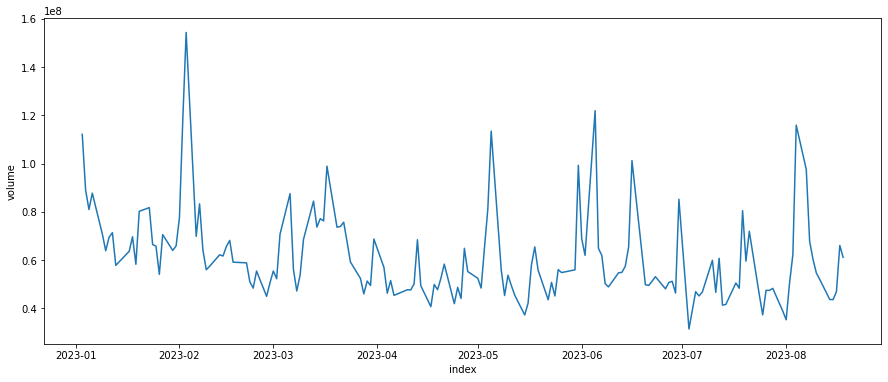

In [10]:
plt.figure(figsize=(15, 6))
sns.lineplot(apple.volume)
plt.show()

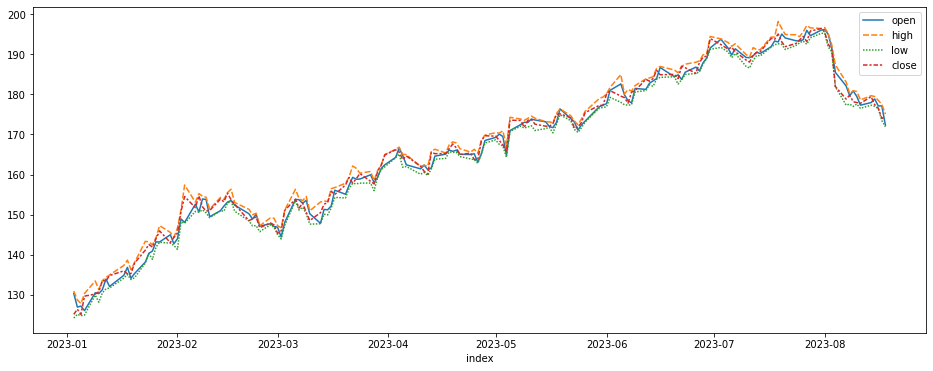

In [11]:
plt.figure(figsize=(16, 6))
sns.lineplot(apple.drop(columns='volume'))
plt.show()

## Stationarity

### Volume
Trade volume seems fairly stationary. Let's test that.

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
adft = adfuller(apple.volume, autolag="AIC")

In [14]:
# Displaying our results as a dataframe
output_df = pd.DataFrame({"Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"], "Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]})
print(output_df)

                        Metric        Values
0              Test Statistics -7.660289e+00
1                      p-value  1.695779e-11
2             No. of lags used  0.000000e+00
3  Number of observations used  1.570000e+02
4          critical value (1%) -3.472703e+00
5          critical value (5%) -2.880132e+00
6         critical value (10%) -2.576683e+00


#### Conclusion
We have strong evidence (p-value << 0.05) against the null hypothesis, so we accept the alternative, that the trading volume series is in fact stationary

## Forecasting (Initial)

In [15]:
tscv = TimeSeriesSplit(n_splits=2, test_size=apple.shape[0]//10)

for train_index, test_index in tscv.split(apple):
    train = apple.iloc[train_index]
    test = apple.iloc[test_index]

### Volume

In [16]:
model = auto_arima(train.volume, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train.volume)

forecast = pd.DataFrame()
forecast['prediction'] = model.predict(n_periods=len(test.volume))
forecast.set_index(test.index, inplace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5122.784, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5157.782, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5141.551, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5130.338, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5155.870, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5124.239, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5126.747, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5123.321, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5125.053, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5123.484, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5128.620, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5118.047, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


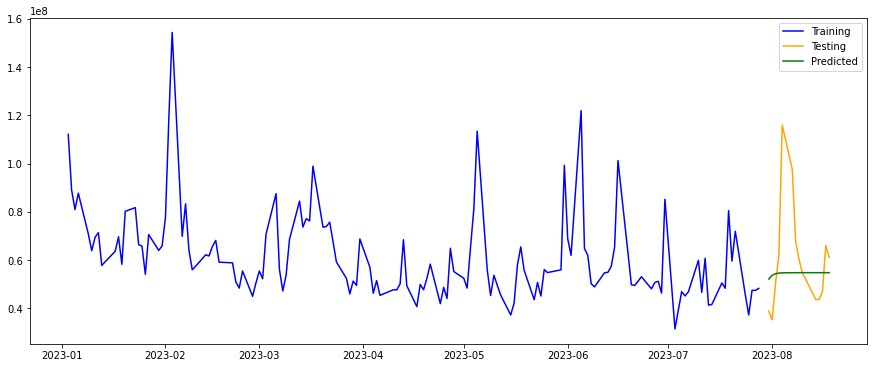

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(train.volume, label="Training", color="blue")
plt.plot(test.volume, label="Testing", color="orange")
plt.plot(forecast, label="Predicted", color="green")
plt.legend(loc='best')
plt.show()

#### Conclusion.
We get a bad prediction. This is most likely because we have not done the proper preprocessing on our data.

### Price
We will use one of the prices since they are roughly the same.

In [18]:
model = auto_arima(train.high, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train.high)

forecast = pd.DataFrame()
forecast['prediction'] = model.predict(n_periods=len(test.high))
forecast.set_index(test.index, inplace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=610.366, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=610.493, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=609.909, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=615.449, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=609.484, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=610.044, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=611.632, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=618.682, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.957 seconds


C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


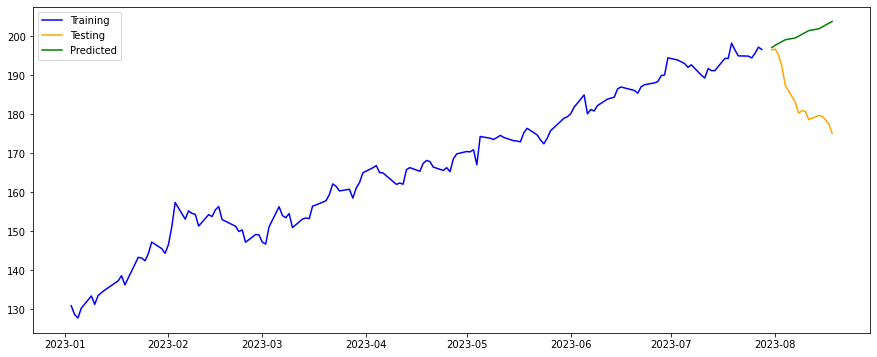

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(train.high, label="Training", color="blue")
plt.plot(test.high, label="Testing", color="orange")
plt.plot(forecast, label="Predicted", color="green")
plt.legend(loc='best')
plt.show()

#### Conclusion
It captures the trend, unable to anticipate the dip. This may be a good reason for detrending the series.

## Decomposition

### Period
Our dataset has daily observations (or at least it should). So in specifying `period=` we are specifying the number of days. We will try meaningful numbers such as 7, 14, 21, 28 for 1, 2, 3, 4 weeks and 30 days for a month.

### Volume

In [20]:
add_decomp_vol = seasonal_decompose(apple.volume, model="additive", period=14)
mult_decomp_vol = seasonal_decompose(apple.volume, model="multiplicative", period=14)

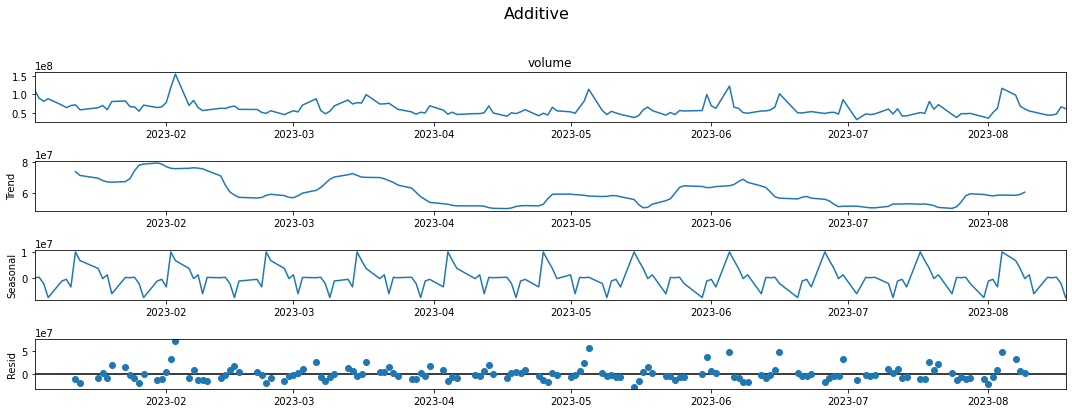

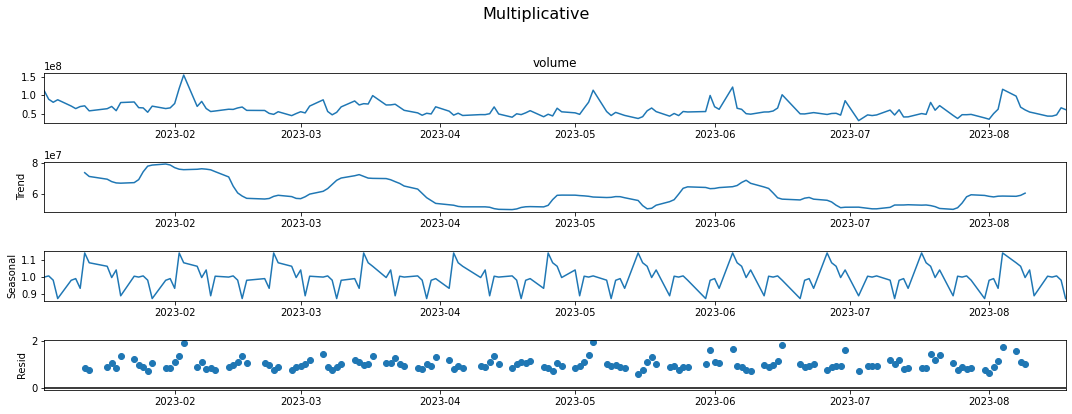

In [21]:
plt.rcParams.update({'figure.figsize' : (15, 6)})
add_decomp_vol.plot().suptitle("Additive", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
mult_decomp_vol.plot().suptitle("Multiplicative", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Intermediate Observations
For the volume series, both multiplicative and additive approaches appear to result in similar decompositions, with differences in the residuals. 

### Price

In [22]:
add_decomp_price = seasonal_decompose(apple.high, model="additive", period=7)
mult_decomp_price = seasonal_decompose(apple.high, model="multiplicative", period=7)

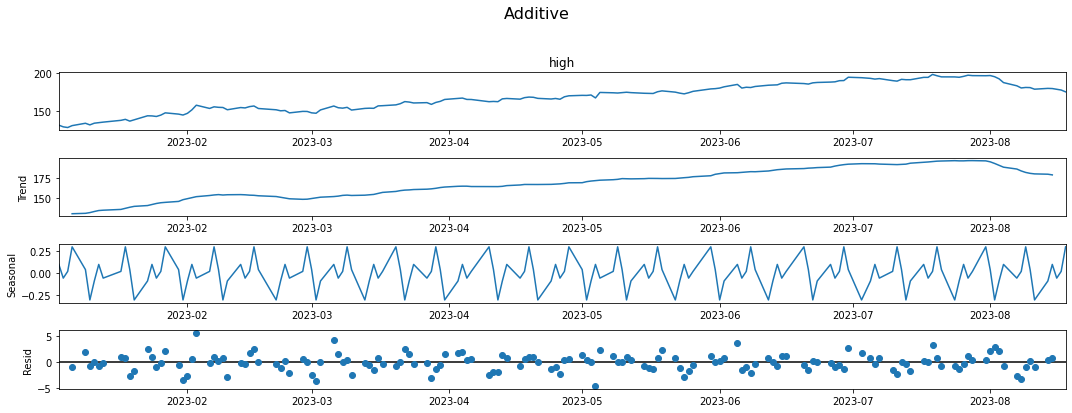

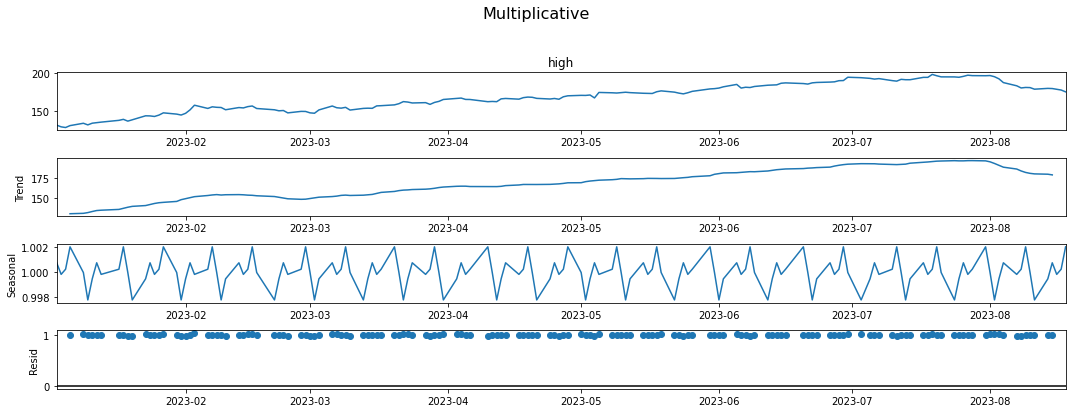

In [23]:
plt.rcParams.update({'figure.figsize' : (15, 6)})
add_decomp_price.plot().suptitle("Additive", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
mult_decomp_price.plot().suptitle("Multiplicative", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Detrending
We will remove the trend component in the series and try to predict on the resulting stationary series.

In [24]:
detrended = apple.high - add_decomp_price.trend
detrended_ = detrended.dropna()

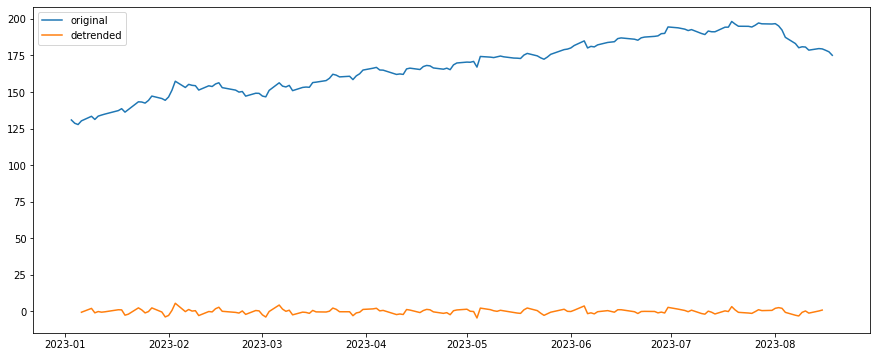

In [25]:
plt.plot(apple.high, label="original")
plt.plot(detrended_, label="detrended")
plt.legend(loc='best')
plt.show()

## Forecasting (Further)

In [26]:
tscv = TimeSeriesSplit(n_splits=2, test_size=detrended_.shape[0]//10)

for train_index, test_index in tscv.split(detrended_):
    train = detrended_.iloc[train_index]
    test = detrended_.iloc[test_index]

In [27]:
model = auto_arima(detrended_, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = pd.DataFrame()
forecast['prediction'] = model.predict(n_periods=len(test))
forecast.set_index(test.index, inplace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=531.451, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=573.033, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=566.224, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=562.754, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=571.076, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=564.723, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=531.448, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=550.868, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=557.464, Time=0.04 sec
 ARIMA

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


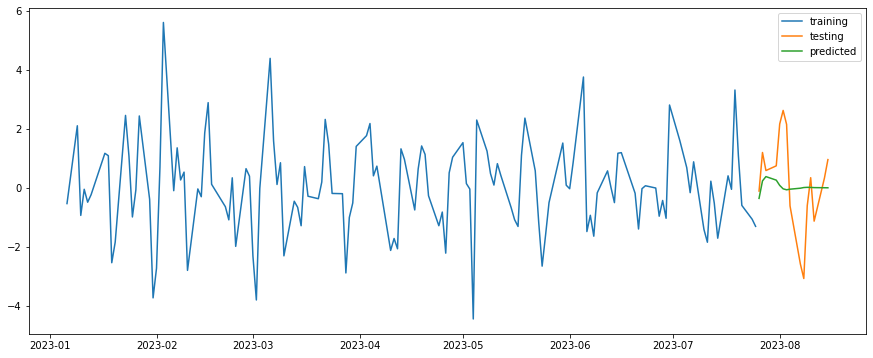

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(train, label="training")
plt.plot(test, label="testing")
plt.plot(forecast, label="predicted")
plt.legend(loc='best')
plt.show()

### Conclusion
It does a little better (based only on visual inspection) but it still fails to capture the pattern in the time series.

## Seasonality

In [41]:
seasonal = add_decomp_price.seasonal

In [53]:
tscv = TimeSeriesSplit(n_splits=2, test_size=len(seasonal)//10)
for train_index, test_index in tscv.split(seasonal):
    train = seasonal[train_index]
    test = seasonal[test_index]

In [59]:
model = auto_arima(seasonal, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = pd.DataFrame()
forecast['prediction'] = model.predict(n_periods=len(test))
forecast.set_index(test.index, inplace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-112.316, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-111.414, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-114.288, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.206 seconds


C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


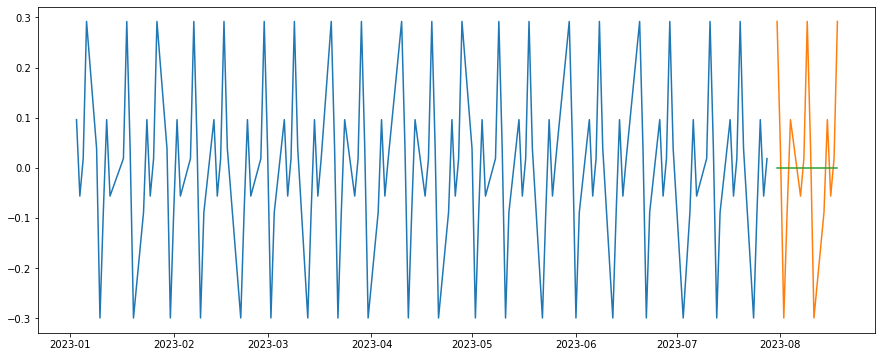

In [61]:
plt.plot(train, label="Training")
plt.plot(test, label="Testing")
plt.plot(forecast, label="Predicted")

## Conclusion
For a lot of the stationary series, we find that the model is unable to capture the pattern but instead flattens out at its mean. I am unsure as to why this occurs.